In [96]:
import torch as t
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
import matplotlib.pyplot as plt
import einops
from torch.optim.lr_scheduler import StepLR

# Check for GPU availability
device = t.device("cuda" if t.cuda.is_available() else "cpu")

class CustomGPT2Model(GPT2LMHeadModel):
    """
    Custom GPT2 Model that allows setting a custom embedding for a specific token.
    """
    def __init__(self, config):
        super().__init__(config)

    def forward(self, input_ids=None, inputs_embeds=None, magic_token_vector=None, magic_token_pos = None, **kwargs):
        if inputs_embeds is None:
            inputs_embeds = self.transformer.wte(input_ids)
        
        if magic_token_vector is not None and magic_token_pos is not None:
            embedding_matrix = self.transformer.wte.weight
            custom_embed = embedding_matrix[magic_token_vector]
            inputs_embeds[0, magic_token_pos] = custom_embed

        return super().forward(inputs_embeds=inputs_embeds, **kwargs)

In [3]:
def tokenize_input(tokenizer, input_text, magic_word):
    """
    Tokenize input text and find the positions of a magic_word.
    """
    tokens = tokenizer.encode(input_text, return_tensors='pt')
    magic_word_tokens = tokenizer.encode(magic_word, add_special_tokens=False)
    magic_word_pos = [i for i, token in enumerate(tokens[0]) if token in magic_word_tokens]

    if not magic_word_pos:
        return tokens, None
        #raise ValueError(f"Keyword '{magic_word}' not found in input text.")
    return tokens, magic_word_pos[0]

In [4]:
def create_modified_embeddings(tokens, magic_token_pos, magic_token_vector, model):
    inputs_embeds = model.transformer.wte.weight[tokens]
    embedding_matrix = model.transformer.wte.weight
    magic_token_embed = einops.einsum(embedding_matrix, magic_token_vector.to(device), ' d_vocab d_model, d_vocab -> d_model ')
    if magic_token_pos != None:
        inputs_embeds[0, magic_token_pos] = magic_token_embed

    return inputs_embeds

In [5]:
def test_create_modified_embeddings(tokenizer,model):
    defaul_sentence = " It is summer. The weather is"

    altered_sentence = " It is winter. The weather is"

    magic_word = " winter"

    summer_vector = t.zeros(model.config.vocab_size)
    summer_vector[tokenizer.encode(" summer")[0]] = 1

    winter_vector = t.zeros(model.config.vocab_size)
    winter_vector[tokenizer.encode(" winter")[0]] = 1

    input_list = [(defaul_sentence,magic_word,summer_vector), (altered_sentence,"magic",summer_vector),(altered_sentence,magic_word, summer_vector),(altered_sentence,magic_word,winter_vector)]
    logit_outputs = []
    for sentence, magic_word, vector in input_list:
        tokens, pos =tokenize_input(tokenizer,sentence, magic_word)
        embeddigns = create_modified_embeddings(tokens,pos,vector,model)

        logit_outputs.append(model.forward(inputs_embeds=embeddigns))
    logit_outputs.append(model.forward(t.tensor(tokenizer.encode(defaul_sentence)).to(device)))
    logit_outputs.append(model.forward(t.tensor(tokenizer.encode(altered_sentence)).to(device)))

    return logit_outputs


tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
logit_outputs = test_create_modified_embeddings(tokenizer,model)



In [6]:
print((logit_outputs[0].logits == logit_outputs[2].logits).all())
print((logit_outputs[1].logits == logit_outputs[3].logits).all())
print((logit_outputs[0].logits == logit_outputs[4].logits).all())
print((logit_outputs[0].logits == logit_outputs[1].logits).all())

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')


In [7]:
tokenizer.encode("hello")

[31373]

In [8]:
def intialise_random_token_vector(model):
    """
    Returns a random unit-norm vector of length vocab_size
    """
    vocab_size = model.config.vocab_size
    magic_token_vector = t.rand(vocab_size, device=device)
    magic_token_vector /= magic_token_vector.sum()
    magic_token_vector = t.nn.Parameter(magic_token_vector, requires_grad=True)

    return magic_token_vector


In [129]:
from tqdm import tqdm

def train_token_vector(model, tokens, magic_word_pos, target_token_id, magic_token_vector, lr=0.01, epochs=500, l1_lambda=0.01, logging_ids= []):
    """
    Perform gradient descent on the magic_token_vector which loss function given by cross-entopy 
    between predicted last token and target_token
    """
    loss_values = []
    optimizer = AdamW([magic_token_vector], lr=lr)

    target_vector = t.zeros(model.config.vocab_size).to(device)
    target_vector[target_token_id] = 1

    # All n_log_step time steps, print the 3 top rated tokens
    n_log_step = 10

    ids_logit_logs = [[] for _ in logging_ids]

    with tqdm(total=epochs, desc="Training Progress") as pbar:
        for epoch in range(epochs):
            optimizer.zero_grad()
            embeddings = create_modified_embeddings(tokens, magic_word_pos, magic_token_vector, model)
            outputs = model.forward(inputs_embeds=embeddings)

            Loss = t.nn.functional.cross_entropy(outputs.logits[0, -1, :], target_vector)

            # L1 regularization
            l1_loss = l1_lambda * t.norm(magic_token_vector, 1)
            Loss += l1_loss

            Loss.backward()
            t.nn.utils.clip_grad_norm_([magic_token_vector], max_norm=10.)
            optimizer.step()
            #magic_token_vector = magic_token_vector**2
            with t.no_grad():  # Temporarily disable gradient tracking
                
                magic_token_vector /= magic_token_vector.norm()
                #keep all entries positive
                


            loss_values.append(Loss.item())
            pbar.set_postfix({"Loss": Loss.item()})
            pbar.update(1)
            for i, id in enumerate(logging_ids):
                ids_logit_logs[i].append(magic_token_vector[id].item()**2/magic_token_vector.norm().item())

            if (epoch % n_log_step) == 0:
            
                top_tokens = t.argsort(magic_token_vector)[-3:]
                top_tokens = [tokenizer.decode([token]) for token in top_tokens]
                print(f"Top tokens: {top_tokens}")
    return loss_values, ids_logit_logs


In [145]:
print(tokenizer.encode((" magic")))
print(tokenizer.encode((" 4")))



[5536]
[604]


In [160]:
right_id = tokenizer.encode(" 4")[0]

logging_ids = [right_id]
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = CustomGPT2Model.from_pretrained('gpt2').to(device)
magic_token_vector = intialise_random_token_vector(model)
input_text = "(1 + 5 = 6)(2 + magic ="
magic_word = " magic"
tokens, magic_word_pos = tokenize_input(tokenizer, input_text, magic_word)
target_token_id = tokenizer.encode(" 6")[0]


#loss_values, ids_logit_logs = train_token_vector(model, tokens, magic_word_pos, target_token_id, magic_token_vector, lr = 0.001, epochs = 1000, l1_lambda = 0.1, logging_ids = logging_ids)

In [199]:
import numpy as np
solution_tokens = tokens
solution_tokens[0, magic_word_pos] = right_id


print(tokenizer.decode(solution_tokens[0]))
solution_logits = model.forward(t.tensor(solution_tokens).to(device)).logits[0, -1, :]
solution_probs = t.nn.functional.softmax(solution_logits, dim=-1).tolist()


top_indices = np.argsort(solution_probs)[-10:][::-1]
for token in top_indices:
    #print(token)
    print(tokenizer.decode([token]))
    print(solution_probs[token])


(1 + 5 = 6)(2 + 4 =
 5
0.31059178709983826
 7
0.3077353835105896
 6
0.1349637508392334
 8
0.05430525913834572
 9
0.04330616816878319
 4
0.03902250528335571
 3
0.028989553451538086
 10
0.015874546021223068
 2
0.009390300139784813
 11
0.007993924431502819


/tmp/ipykernel_5131/2885388750.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  solution_logits = model.forward(t.tensor(solution_tokens).to(device)).logits[0, -1, :]


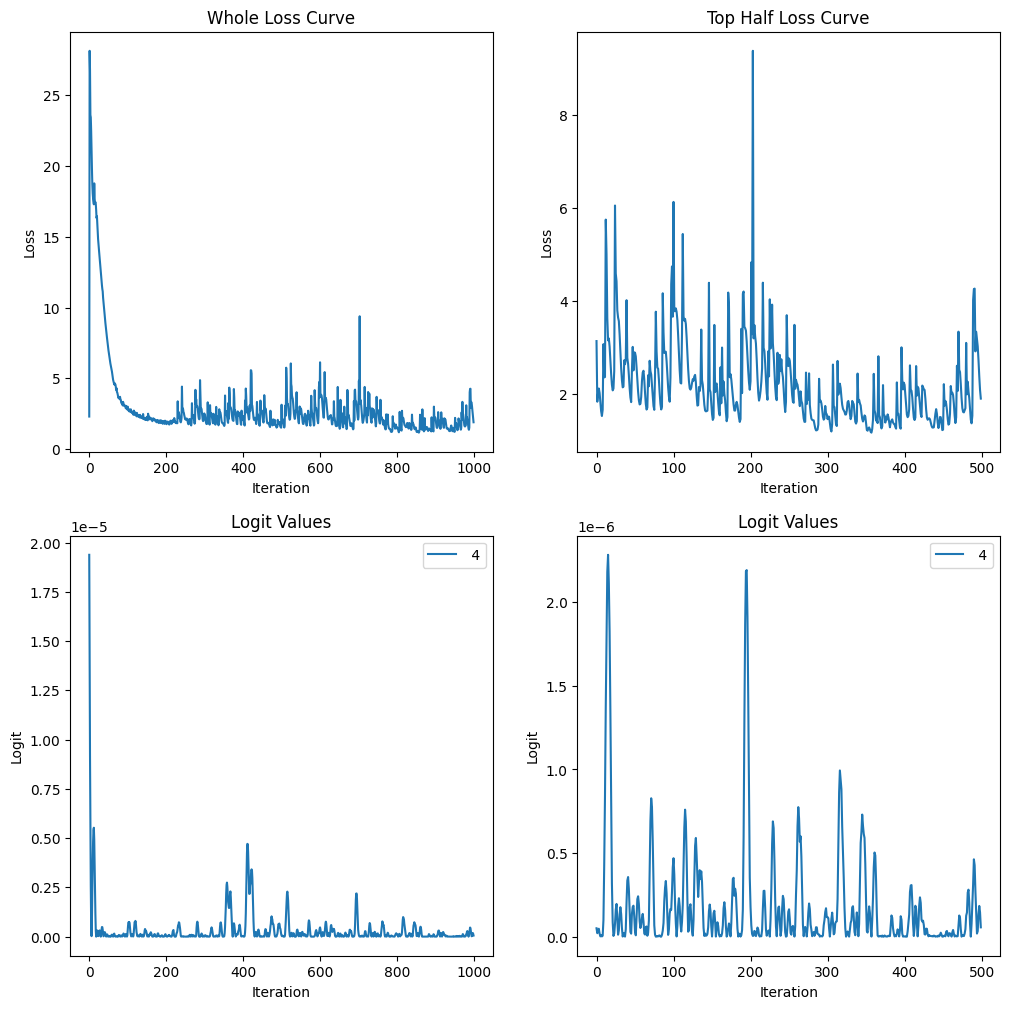

In [151]:

# Plot the whole loss curve
import matplotlib.pyplot as plt

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

# Plot the whole loss curve
ax1.plot(loss_values)
ax1.set_title('Whole Loss Curve')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')

# Plot the second  half of the loss curve
ax2.plot(loss_values[len(loss_values)//2:])
ax2.set_title('Top Half Loss Curve')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss')

# Plot the bottom whole token logit curve
for i, id in enumerate(logging_ids):
    ax3.plot(ids_logit_logs[i], label=tokenizer.decode([id]))
ax3.set_title('Logit Values')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Logit')
ax3.legend()

# Plot the bottom half token logit curve
for i, id in enumerate(logging_ids):
    ax4.plot(ids_logit_logs[i][len(ids_logit_logs[i])//2:], label=tokenizer.decode([id]))
ax4.set_title('Logit Values')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Logit')
ax4.legend()


In [87]:
import pandas as pd
top_indices = t.argsort(magic_token_vector, descending=True)[:10]
decoded_tokens = [tokenizer.decode(token) for token in top_indices.tolist()]
# Create a dictionary with the data
data = {'Token Index': top_indices.tolist(),
    'Contribution': magic_token_vector[top_indices].tolist(),
    'Decoded Token': decoded_tokens}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
df


,Token Index,Contribution,Decoded Token
0,3252,0.137437,fear
1,30665,0.128719,obia
2,16132,0.125774,Fear
3,37798,0.118672,Fear
4,43045,0.116238,instinctively
5,24133,0.110857,reflex
6,26844,0.104010,fearful
7,7787,0.098174,afraid
8,33188,0.096664,fearing
9,10251,0.094415,fears
